In [1]:
%cd ..

/home/radaimi/Documents/influence-release-master


In [39]:
from __future__ import division
from __future__ import print_function
from __future__ import absolute_import
from __future__ import unicode_literals  

import math
import copy
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn.linear_model as linear_model
import sklearn.preprocessing as preprocessing
import scipy
import scipy.linalg as slin
import scipy.sparse.linalg as sparselin
import scipy.sparse as sparse
from influence.logisticRegressionWithLBFGS import LogisticRegressionWithLBFGS

sns.set(color_codes=True)
import sys
sys.path.append("/home/radaimi/Documents/influence-release-master")

from scripts.load_mnist import load_mnist
from influence.image_utils import plot_flat_colorimage, plot_flat_colorgrad

import tensorflow as tf
from tensorflow.contrib.learn.python.learn.datasets import base

from sklearn.metrics.pairwise import rbf_kernel
from sklearn.metrics.pairwise import sigmoid_kernel

from influence.inceptionModel import BinaryInceptionModel
from influence.smooth_hinge import SmoothHinge
from influence.binaryLogisticRegressionWithLBFGS import BinaryLogisticRegressionWithLBFGS
import influence.dataset as dataset
from influence.dataset import DataSet
from influence.dataset_poisoning import generate_inception_features
from influence.all_CNN_c import All_CNN_C

%matplotlib inline
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [40]:
dataset_name = 'MNIST_1_7'
sns.set_style('white')
data_sets = load_mnist("/home/radaimi/Document/influence-release-master/data")

Extracting /home/radaimi/Document/influence-release-master/data/train-images-idx3-ubyte.gz
Extracting /home/radaimi/Document/influence-release-master/data/train-labels-idx1-ubyte.gz
Extracting /home/radaimi/Document/influence-release-master/data/t10k-images-idx3-ubyte.gz
Extracting /home/radaimi/Document/influence-release-master/data/t10k-labels-idx1-ubyte.gz


In [41]:
## 1 and 7 
pos_class = 1
neg_class = 7

X_train = data_sets.train.x
Y_train = data_sets.train.labels
X_test = data_sets.test.x
Y_test = data_sets.test.labels

X_train, Y_train = dataset.filter_dataset(X_train, Y_train, pos_class, neg_class)
X_test, Y_test = dataset.filter_dataset(X_test, Y_test, pos_class, neg_class)

lr_train = DataSet(X_train, np.array((Y_train + 1) / 2, dtype=int))
lr_validation = None
lr_test = DataSet(X_test, np.array((Y_test + 1) / 2, dtype=int))
data_sets = base.Datasets(train=lr_train, validation=lr_validation, test=lr_test)

test_idx = 20

In [42]:
num_classes = 2


def get_Y_pred_correct_cnn(model):
    Y_test = model.data_sets.test.labels
    if np.min(Y_test) < -0.5:
        Y_test = (np.copy(Y_test) + 1) / 2        
    Y_pred = model.sess.run(model.preds, feed_dict=model.all_test_feed_dict)
    Y_pred_correct = np.zeros([len(Y_test)])
    for idx, label in enumerate(Y_test):
        Y_pred_correct[idx] = Y_pred[idx, int(label)]
    return Y_pred_correct

gamma = 0.05
weight_decay = 0.0001

tf.reset_default_graph()

input_dim = data_sets.train.x.shape[1]
print(input_dim)

input_side = 28
input_channels = 1
input_dim = input_side * input_side * input_channels
weight_decay = 0.01
use_bias = False
batch_size = 100
initial_learning_rate = 0.001 
keep_probs = None
decay_epochs = [1000, 10000]
max_lbfgs_iter = 1000

temps = [0, 0.001, 0.1]
num_temps = len(temps)

num_params = 784


# Get weights from hinge
# Train with hinge
hinge_model = SmoothHinge(
    temp=0,
    use_bias=use_bias,
    input_dim=input_dim,
    weight_decay=weight_decay,
    num_classes=num_classes,
    batch_size=batch_size,
    data_sets=data_sets,
    initial_learning_rate=initial_learning_rate,
    keep_probs=keep_probs,
    decay_epochs=decay_epochs,
    mini_batch=False,
    train_dir='output',
    log_dir='log',
    model_name='MNIST_hinge_t-0')
    
hinge_model.train()
hinge_W = hinge_model.sess.run(hinge_model.params)[0]

# Then load weights into smoothed version
tf.reset_default_graph()
hinge_model = SmoothHinge(
    temp=0.001,
    use_bias=use_bias,
    input_dim=input_dim,
    weight_decay=weight_decay,
    num_classes=num_classes,
    batch_size=batch_size,
    data_sets=data_sets,
    initial_learning_rate=initial_learning_rate,
    keep_probs=keep_probs,
    decay_epochs=decay_epochs,
    mini_batch=False,
    train_dir='output',
    log_dir='log',
    model_name='MNIST_hinge_t-0.001')

params_feed_dict = {}
params_feed_dict[hinge_model.W_placeholder] = hinge_W
hinge_model.sess.run(hinge_model.set_params_op, feed_dict=params_feed_dict)

hinge_predicted_loss_diffs = hinge_model.get_influence_on_test_loss(
    [test_idx], 
    np.arange(len(hinge_model.data_sets.train.labels)),
    force_refresh=True)

784
Total number of parameters: 784
Using normal model
SVM training took 333 iter.
After SVM training: 
Train loss (w reg) on all data: 0.4960471
Train loss (w/o reg) on all data: 0.48660687
Test loss (w/o reg) on all data: 0.47964886
Train acc on all data:  0.5178241129981503
Test acc on all data:   0.5233472029588534
Norm of the mean of gradients: 0.08435256
Norm of the params: 1.3740622
Total number of parameters: 784
Norm of test gradient: 0.0
Function value: 0.0
Split function value: 0.0, -0.0
Predicted loss diff on train_idx 5: 0.0
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 1
         Function evaluations: 2
         Gradient evaluations: 2
         Hessian evaluations: 0
Saved inverse HVP to output/MNIST_hinge_t-0.001-cg-normal_loss-test-[20].npz
Inverse HVP took 0.6021881103515625 sec
Multiplying by 11894 train examples took 8.780205965042114 sec


In [43]:
num_classes = 2
input_side = 28
input_channels = 1
input_dim = input_side * input_side * input_channels
weight_decay = 0.01
batch_size = 100
initial_learning_rate = 0.001 
keep_probs = None
decay_epochs = [1000, 10000]
max_lbfgs_iter = 1000

num_params = 784

tf.reset_default_graph()

tf_model = BinaryLogisticRegressionWithLBFGS(
    input_dim=input_dim,
    weight_decay=weight_decay,
    max_lbfgs_iter=max_lbfgs_iter,
    num_classes=num_classes, 
    batch_size=batch_size,
    data_sets=data_sets,
    initial_learning_rate=initial_learning_rate,
    keep_probs=keep_probs,
    decay_epochs=decay_epochs,
    mini_batch=False,
    train_dir='output',
    log_dir='log',
    model_name='mnist-17_logreg')

tf_model.train()

num_train = len(tf_model.data_sets.train.labels)
print(num_train)
influences = tf_model.get_influence_on_test_loss(
    [test_idx], 
    np.arange(len(tf_model.data_sets.train.labels)),
    force_refresh=True)

x_test = tf_model.data_sets.test.x[test_idx, :]
y_test = tf_model.data_sets.test.labels[test_idx]

distances = dataset.find_distances(x_test, X_train)
flipped_idx = tf_model.data_sets.train.labels != y_test
print(num_train, len(flipped_idx))
hinge_margins_test = hinge_model.sess.run(hinge_model.margin, feed_dict=hinge_model.all_test_feed_dict)
hinge_margins_train = hinge_model.sess.run(hinge_model.margin, feed_dict=hinge_model.all_train_feed_dict)
logreg_Y_pred_correct = get_Y_pred_correct_cnn(tf_model)


np.savez(
    'output/mnist_logreg_lbfgs', 
    test_idx=test_idx,
    distances=distances,
    flipped_idx=flipped_idx,
    hinge_margins_test=hinge_margins_test,
    hinge_margins_train=hinge_margins_train,
    logreg_Y_pred_correct=logreg_Y_pred_correct,
    hinge_predicted_loss_diffs=hinge_predicted_loss_diffs,
    logreg_predicted_loss_diffs=influences
)

Total number of parameters: 784
Using normal model


/home/radaimi/Documents/influence-release-master/influence_env/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:110: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


LBFGS training took [25] iter.
After training with LBFGS: 
Train loss (w reg) on all data: 0.060587756
Train loss (w/o reg) on all data: 0.03504161
Test loss (w/o reg) on all data: 0.039349467
Train acc on all data:  0.9926013115856734
Test acc on all data:   0.9912159038372631
Norm of the mean of gradients: 1.7268694e-06
Norm of the params: 2.2603605
11894
Norm of test gradient: 0.33864272
Function value: -1.4928525686264038
Split function value: 1.4928580522537231, -2.9857106
Predicted loss diff on train_idx 5: -2.4348265930386338e-06
Function value: -1.5424609184265137
Split function value: 1.4435408115386963, -2.9860017
Predicted loss diff on train_idx 5: -3.102317399811861e-06
Function value: -1.5548580884933472
Split function value: 1.5520581007003784, -3.1069162
Predicted loss diff on train_idx 5: -9.888750053873298e-07
Function value: -1.555019497871399
Split function value: 1.554571270942688, -3.1095908
Predicted loss diff on train_idx 5: -1.4268511748722828e-06
Function value

In [44]:
f = np.load('output/mnist_logreg_lbfgs.npz')
    
test_idx = f['test_idx']
distances = f['distances']
flipped_idx = f['flipped_idx']
hinge_margins_test = f['hinge_margins_test']
hinge_margins_train = f['hinge_margins_train']
logreg_Y_pred_correct = f['logreg_Y_pred_correct']
hinge_predicted_loss_diffs = f['hinge_predicted_loss_diffs']
logreg_predicted_loss_diffs = f['logreg_predicted_loss_diffs']

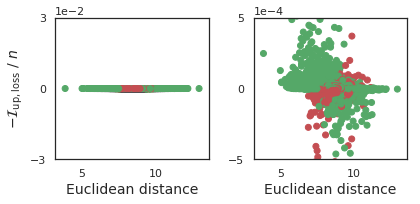

In [55]:
sns.set_style('white')
fontsize=14

fig, axs = plt.subplots(1, 2, sharex=True, sharey=False, figsize=(6, 3))

num_train = len(flipped_idx)
color_vec = np.array(['g'] * num_train)
color_vec[flipped_idx] = 'r'
color_vec = list(color_vec)

axs[0].scatter(distances, hinge_predicted_loss_diffs, color=color_vec)
axs[0].set_ylim(-0.03, 0.03)
axs[0].set_yticks((-0.03, 0, 0.03))
axs[0].ticklabel_format(style='sci', scilimits=(0,0), axis='y')
axs[0].set_xlabel('Euclidean distance', fontsize=fontsize)
axs[0].set_ylabel('$-\mathcal{I}_\mathrm{up, loss} \ /\ n$', fontsize=fontsize)

axs[1].scatter(distances, logreg_predicted_loss_diffs, color=color_vec)
axs[1].set_ylim(-0.0005, 0.0005)
axs[1].set_yticks((-0.0005, 0, 0.0005))
axs[1].ticklabel_format(style='sci', scilimits=(0,0), axis='y')
axs[1].set_xlabel('Euclidean distance', fontsize=fontsize)

plt.tight_layout()
plt.savefig('fig-mnist-logreg-dist.png', dpi=600, bbox_inches='tight')

In [52]:
def plot_flat_colorimage(X, y, pos_class=1, neg_class=-1, side=32):
    X = np.reshape(X, (side, side))
    if y == 1:
        label = pos_class
    else:
        label = neg_class
    with sns.axes_style("white"):
        f, ax = plt.subplots(figsize=(6,6))
        ax.set_title('Label is %s' % label)        
        ax.imshow(X, interpolation='none')  
        plt.show()
        f.savefig('fig-mnist-test-image.png', dpi=600, bbox_inches='tight')


Test image:
-1 -0.0 0.9612236022949219


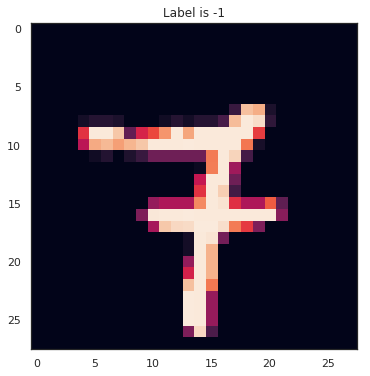

Top from SmoothHinge:
3967 1 8.7492075 1.8423716 0.0
3968 -1 10.762758 -0.0 0.0
3969 1 8.806748 2.4303021 0.0
3960 -1 8.215269 -0.0 0.0
11893 1 8.607339 1.2404392 0.0


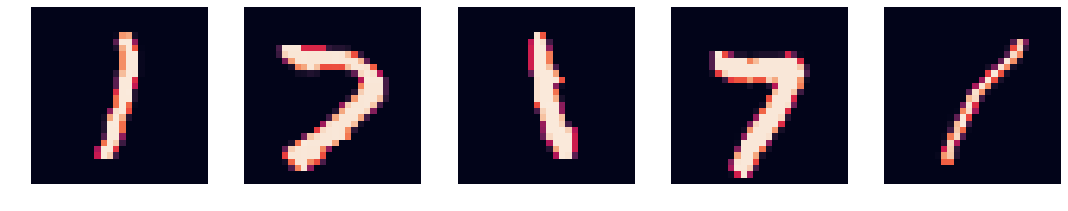

Top from LogReg:
8917 -1 6.2627254 0.0011000500940887671
10337 -1 6.9111056 0.0011054455622597184
2989 -1 7.298802 0.0011307256290326102
695 -1 6.5737295 0.0011682235354713297
8581 -1 6.1682534 0.0015989489288355736


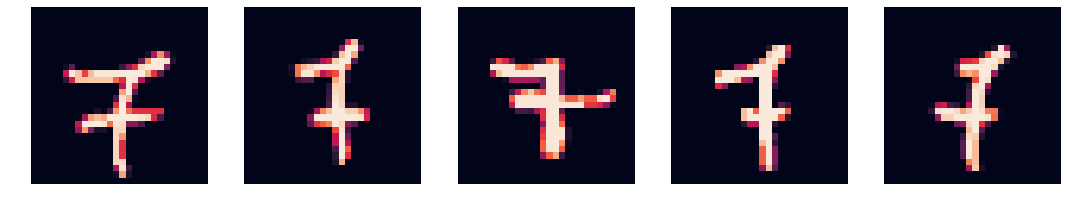

Helpful Train (One):
36 1262 1 9.882146 0.0003701834713127787


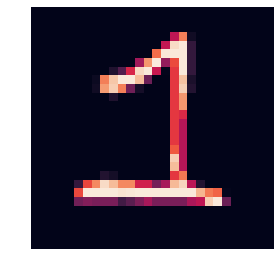

In [54]:
print('Test image:')
print(Y_test[test_idx], hinge_margins_test[test_idx], logreg_Y_pred_correct[test_idx])
plot_flat_colorimage(X_test[test_idx, :], 0, side=28)
    
print('Top from SmoothHinge:')
fig, axs = plt.subplots(1, 5, figsize=(15,3))
for counter, train_idx in enumerate(np.argsort(hinge_predicted_loss_diffs)[-5:]):
    print(train_idx, Y_train[train_idx], distances[train_idx], hinge_margins_train[train_idx], hinge_predicted_loss_diffs[train_idx])
    x_train = X_train[train_idx, :]
    axs[counter].imshow(np.reshape(x_train, (28,28)), interpolation='none')  
    axs[counter].axis('off')
plt.tight_layout()
plt.show()

print('Top from LogReg:')
fig, axs = plt.subplots(1, 5, figsize=(15,3))
for counter, train_idx in enumerate(np.argsort(logreg_predicted_loss_diffs)[-5:]):
    print(train_idx, Y_train[train_idx], distances[train_idx], logreg_predicted_loss_diffs[train_idx])    
    x_train = X_train[train_idx, :]
    axs[counter].imshow(np.reshape(x_train, (28,28)), interpolation='none')  
    axs[counter].axis('off')
plt.tight_layout()
plt.show()
fig.savefig('fig-mnist-logreg.png', dpi=600, bbox_inches='tight')

print('Helpful Train (One):')
counter = 0
for i, train_idx in enumerate(np.argsort(logreg_predicted_loss_diffs)[:-50:-1]):
    if Y_train[train_idx] == 1.0:
        print(i, train_idx, Y_train[train_idx], distances[train_idx], logreg_predicted_loss_diffs[train_idx])    
        x_train = X_train[train_idx, :]
        plt.imshow(np.reshape(x_train,(28,28)), interpolation='none')  
        plt.axis('off')
        counter -= 1
    if counter == -1:
        break
plt.tight_layout()
plt.savefig('fig-mnist-helpful-train.png', dpi=600, bbox_inches='tight')
plt.show()